adapted slightly from https://github.com/Djiffit/face-decoding-with-model-inversion

In [12]:
# run this for all imports necessary
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssm

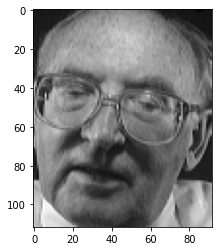

In [2]:
classes = os.listdir('./data/processed/train')
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

def show_img(im):
    plt.imshow(im.reshape(112, 92), cmap='gray')
    plt.show()
    
def one_hot(x):
    vec = [0] *len(classes)
    vec[x] = 1
    return vec
    
train = test= 0
train_x, train_y = ([0]) * 280, ([0]) * 280
test_x, test_y = ([0]) * 120, ([0]) * 120
asd = []

for c in os.listdir('./data/processed/train/'):
    for faces in os.listdir('./data/processed/train/'+c):
        img = np.array(Image.open('./data/processed/train/'+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir('./data/processed/test/'):
    for faces in os.listdir('./data/processed/test/'+c):
        img = np.array(Image.open('./data/processed/test/'+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([x.flatten() for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

train_x = train_x/255
test_x = test_x/255
show_img(train_x[0])

In [3]:
class MLPModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(MLPModel, self).__init__()
        
        self.linear1 = torch.nn.Linear(D_in, 3000)
        self.linear2 = torch.nn.Linear(3000, D_out)
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        x = torch.sigmoid(self.linear1(x))
        x = F.log_softmax(self.linear2(x), dim=1)
        return x

class SMModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(SMModel, self).__init__()
        
        self.linear1 = torch.nn.Linear(D_in, D_out)
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        x = F.log_softmax(self.linear1(x), dim=1)
        return x

model = SoftMaxModel(len(train_x[0]), len(classes))
    
steps = 20
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-1)
for i in range(steps):
    optimizer.zero_grad()
    y_hat = model(torch.Tensor(train_x))
    print(y_hat)
    print(train_y)
    loss = criterion(y_hat, torch.LongTensor(train_y))
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(i, loss))

### Denoising Autoencoder
This classifier is an example of a deep architecture, and consists of two
hidden layers and one softmax output layer. The two hidden layers, which have 1000 and 300 sigmoid units, are each
instances of a denoising autoencoder. 

In [3]:
class DAEModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(DAEModel, self).__init__()
        self.dae1enc = torch.nn.Linear(D_in, 1000)
        self.dae1dec = torch.nn.Linear(1000, D_in)
        self.dae2enc = torch.nn.Linear(D_in, 300)
        self.dae2dec = torch.nn.Linear(300, D_in)
        
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        
        # first dae layer
        x = torch.sigmoid(self.dae1enc(x))
        x = torch.sigmoid(self.dae1dec(x))
        
        # second dae layer
        x = torch.tanh(self.dae2enc(x))
        x = self.dae2dec(x)
        return x

In [5]:
class DAEModel2(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(DAEModel2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(D_in, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 300),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(300, 1000),
            nn.ReLU(True),
            nn.Linear(1000, D_in),
            nn.ReLU(True))
        
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
def reshape_img(img):
    return np.reshape(img, (112, 92))

def add_noise(img):
    mean = 0
    var = 0.005
    std = var ** 0.5
    noise = np.random.normal(mean, std, img.shape)
    img = img + noise
    return img

In [6]:
noised_imgs = []
for img in train_x:
    noised_imgs.append(add_noise(reshape_img(img)))

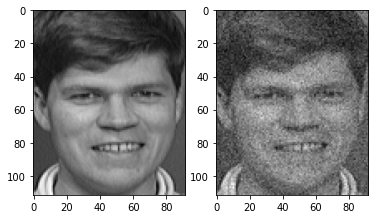

In [7]:
img_nr = 10

fig = plt.figure()
fig.add_subplot(1,2, 1)
plt.imshow(reshape_img(train_x[img_nr]), cmap='gray')

fig.add_subplot(1,2, 2)
plt.imshow(reshape_img(noised_imgs[img_nr]), cmap='gray')
plt.show()

In [8]:
model = DAEModel(len(train_x[0]), len(classes))
# model = DAEModel2(len(train_x[0]), len(classes))

steps = 1000
criterion = torch.nn.MSELoss() #tried MSE, BCE
optimizer = torch.optim.Adam(model.parameters(), lr=9e-5) #tried SGD, Adam


### best result so far: mse, adam, lr=9e-5, 800 epochs, 2x sigmoid --> loss 0.004714
### noise: gaussian, mean=0, var=0.005

### vielleicht weniger gaussian noise
### --> var=0.0005 --> 800 epochs = loss 0.004974
### --> 1000 epochs = loss 0.004010


for epoch in range(steps):
    optimizer.zero_grad()
    y_hat = model(torch.Tensor(noised_imgs))
    loss = criterion(y_hat, torch.Tensor(train_x))
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, loss))

Epoch: 0 	Training Loss: 0.259406
Epoch: 1 	Training Loss: 0.257943
Epoch: 2 	Training Loss: 0.241865


KeyboardInterrupt: 

In [ ]:
img_nr = 39
show = True

output = model(torch.Tensor(train_x))

train_img = torch.Tensor(train_x)[img_nr].view(112,92)
rec_img = output[img_nr].view(112,92).detach().numpy()
rec_img2 = output[img_nr+30].view(112,92).detach().numpy()

if (show):
    fig = plt.figure()
    fig.add_subplot(1,2, 1)
    plt.imshow(train_img, cmap='gray')

    fig.add_subplot(1,2, 2)
    plt.imshow(rec_img, cmap='gray')
    plt.show()
else:
    print(rec_img.shape)
    print(rec_img2.shape)
    print(np.equal(rec_img, rec_img2))

In [ ]:
torch.save(model.state_dict(), 'mse_adam_2xsigmoid_noise=0.0005_epochs=1000.pt')

In [ ]:
pred = ''
def invert(model, img, lr, c, best_loss, best_x, i):
    img = torch.Tensor(img).view(1, -1)
    if not img.requires_grad:
        img.requires_grad = True
        
    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred, torch.LongTensor([c]))
    loss.backward()    
    img = torch.clamp(img - lr * img.grad, 0, 255)

    if loss.detach().numpy() < best_loss and i > 10:
        best_loss = loss.detach().numpy()
        best_x = img.detach().numpy()
        

    filt = np.array([
        [0,-1,0],
        [-1,5,-1],
        [0,-1,0]
    ])
    np_a = np.array([np.clip(x + np.random.normal(2, 2),0,255) for x in img.detach().numpy()])
    i = convolve(np_a.reshape(112, 92), filt)
    
    return best_loss, best_x, np_a.reshape(1, -1)

In [ ]:
for c in classes:
    best_x,best_loss='',float('inf')
    img = np.zeros_like(train_x[0])
    for i in range(100):
        best_loss,best_x,img = invert(model, img, .01, c_to_i(c), best_loss, best_x, i)
    if c=='s34':
        rec = best_x.reshape(112, 92)
        orig = test_x[c_to_i(c)].reshape(112, 92).astype('float32')
        ssmv = ssm(rec,orig)
        msev = mse(rec,orig)
        nrmsev = nrmse(rec,orig)
        fig = plt.figure(figsize=(8, 4))
        fig.suptitle("SSM: {:.4f}, MSE: {:.3f}, NRMSE: {:.3f}".format(ssmv,msev,nrmsev))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(rec, cmap='gray')
        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(orig, cmap='gray')
        # plt.savefig(f'./data/results/class {c}.png')
        plt.show()